In [1]:
import pandas as pd
import LendingClubFunctions as LC
from sklearn.decomposition import PCA
import sklearn as sk
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn import grid_search


%pylab inline
pylab.rcParams['figure.figsize']=(8.0,6.0)
from sklearn.ensemble import AdaBoostRegressor

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Define data location
file1='./data/LoanStats3a.csv'
file2='./data/LoanStats3b.csv'
file3='./data/LoanStats3c.csv'
file4='./data/LoanStats3d.csv'
files=[file1,file2,file3,file4]

In [3]:
cols=['loan_amnt','funded_amnt','total_pymnt', 'loan_status', 'int_rate', 'term',
      'desc', 'grade', 'annual_inc', 'purpose', 'emp_length', 'earliest_cr_line', 
      'revol_util', 'home_ownership', 'sub_grade', 'addr_state', 'dti', 'revol_bal', 'installment', 'last_pymnt_d', 'issue_d']

In [4]:
#Load data in from files
df1=LC.GetData(cols, files)
Trouble=[ 'Charged Off', 'Default', 'Does not meet the credit policy.  Status:Charged Off']
Success=['Fully Paid', 'Does not meet the credit policy.  Status:Fully Paid']
df1=LC.CleanData(df1, Success=Success, Trouble=Trouble)

/Users/admin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


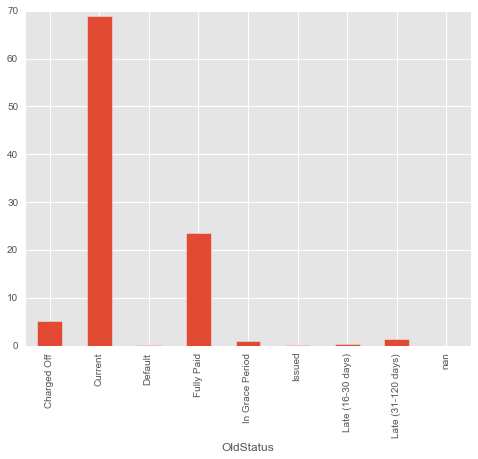

In [5]:
(100*(df1.groupby('OldStatus').count().loan_amnt)/df1.loan_amnt.count()).plot(kind='bar')

In [6]:
class LendingClubTransformer(sk.base.BaseEstimator, sk.base.TransformerMixin):
    """
    A transformer that takes as input a dataframe and a cut-off for variance explained. Then 
    performs PCA on the relevant columns and returns a matrix explaining the requested amount
    of variance
    """
    def __init__(self, cols=[], varExp=100):
        self.cols=cols
        self.varExp=varExp
        self.means=[]
        self.stds=[]
        self.pca=PCA()
        self.ElVarExp=None
        pass

    def fit(self, X, y=[]):
        return self.fit_transform(X)
    
    def fit_transform(self, X, y=[]):
        
        self.means=X.describe().ix['mean']
        self.stds=X.describe().ix['std']
        Xs=X[self.cols].dropna().copy()
        for col in Xs.columns:
            Xs[col]= (Xs[col]-self.means[col])/self.stds[col]

        self.pca.fit(Xs)
        el=np.argmax(self.pca.explained_variance_ratio_.cumsum()>self.varExp)
        self.ElVarExp=el
        Xs=self.pca.transform(Xs)[:, :(self.ElVarExp+1)]
        return Xs

    def transform(self, X):
        Xs=X[self.cols].dropna().copy()
        for col in Xs.columns:
            Xs[col]= (Xs[col]-self.means[col])/self.stds[col]
        Xs=self.pca.transform(Xs)[:, :(self.ElVarExp+1)]
        return Xs

In [7]:
class yLendingClubTransformer(sk.base.BaseEstimator, sk.base.TransformerMixin):
    """
    A transformer that takes as input a dataframe and the desired columns as features and returns the requests label
    """
    def __init__(self, cols=[], label=None):
        self.cols=[col for col in cols]
        self.cols.append(label)
        self.label=label
        pass
    

    def transform(self, X):
        return (X[self.cols].dropna())[self.label].as_matrix()

In [8]:
features=['loan_amnt','annual_inc','earliest_cr_line', 'revol_util','dti', 'int_rate']
#features=['revol_util','dti', 'int_rate']
Transformer=LendingClubTransformer(cols=features, varExp=.95)
dfTrain, dfTest = train_test_split(df1[df1.loan_status!=2].dropna(), test_size=0.4)
yTransformer=yLendingClubTransformer(cols=features, label='Fraction_Of_Total')
y=yTransformer.transform(dfTrain)
yTest=yTransformer.transform(dfTest)
Xtrain=Transformer.fit_transform(dfTrain[features].dropna())
Xtest=Transformer.transform(dfTest[features].dropna())
#Model=RandomForestRegressor(n_estimators=50)

In [9]:
LMCV=grid_search.GridSearchCV(linear_model.Ridge(), {'alpha':(.1, .00001, 10, 100)}, cv=5, verbose=True) 

In [10]:
LMCV.fit(dfTrain[features].dropna(), y)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'alpha': (0.1, 1e-05, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=True)

In [11]:
LMCV.grid_scores_

[mean: 0.14673, std: 0.00797, params: {'alpha': 0.1},
 mean: 0.14673, std: 0.00798, params: {'alpha': 1e-05},
 mean: 0.14393, std: 0.00745, params: {'alpha': 10},
 mean: 0.10162, std: 0.00560, params: {'alpha': 100}]

In [12]:
LMCV.best_estimator_

Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [13]:
LMCV.score(dfTest[features].dropna(), yTest)

0.14904678723041298

In [14]:
predictions=LMCV.predict(dfTest[features].dropna())

In [15]:
np.sqrt(mean_squared_error(yTest, predictions))

0.21478719201848459

In [16]:
import dill
f=open('LinearModel2.txt', 'w')
print >> f, dill.dumps(LMCV)
f.close()